## Area-perimeter self-propelled Voronoi model

After the toy example of notebook 05, let's implement a slightly more complicated model, the self-propelled Voronoi area-perimeter Voronoi (VAP) model of [Bi et al., 2016](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.021011). This 2D model comprises most of the ingredients we will see in more general tissue mechanics simulations, from a coding perspective.

In brief, in the VAP, cells are modeled as the Voronoi tesselation for a series of centroids $\mathbf{v}_i$ (our triangulation vertices). Their overdamped dynamics comprises two terms: self-propulsion and relaxation of an elastic energy:
$$\partial_t \mathbf{v}_i = -\nabla_{\mathbf{v}_i} E_{AP} + v_0 \hat{\mathbf{n}}_i$$
For each cell $i$, $\hat{\mathbf{n}}_i$ is a unit vector (so we will represent it by an angle $\theta_i$) that determines the direction of motion. Units of time are chosen so that the coefficient of $\nabla E_{AP}$ is $1$.
The energy is defined in terms of the Voronoi area $a_i$ and Voronoi perimeter $p_i$ of each cell:
$$E_{AP} = \sum_i k_a(a_i-a_0)^2 + k_p(p_i-p_0)^2 $$
where $k_a, k_p$ are elastic constants, and $a_0, p_0$ are the target area and perimeter. They define the "shape index" $s_0= p_0/\sqrt{a_0}$. The key physics is that above a critical shape index $s_0^*$, the model has a degenerate set of ground states, since for a large $p_0$, there are many polygons with the given target area and perimeter (think floppy balloon).

The orientation $\theta_i$ of each cell is also dynamic. It undergoes rotational diffusion:
$$d\theta_i = D_\theta dW_{t, i} $$
where $dW_{t,i}$ is Brownian motion, independent for each cell $i$, and $D_\theta$ is the diffusion constant.

#### Numerics

The cell array connectivity will be represented by a `HeMesh` (see notebook 01). The geometry is fully described by the triangulation vertex positions, the Voronoi cell centroids. We also need a scalar vertex attribute for the angle $\theta_i$.
To calculate the energy $E_{AP}$, we obtain Voronoi area and perimeter using the `linops` module.
Boundary cells can be handled by "mirroring", i.e., all corners count twice when computing the area/perimeter. Given the energy, JAX autodiff gives us the gradients. To time-evolve the mesh geometry, we can use `diffrax`, like in notebook 05. `diffrax` can also deal with SDEs, like the Langevin equation for cell angles.


**Note** This notebook is an example, and not meant to be numerically efficient!

In [1]:
from typing import Tuple

import dataclasses
import copy

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import jax
import jax.numpy as jnp

import diffrax
import lineax

from jaxtyping import Float, Bool, Int
from enum import IntEnum

import functools

In [2]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
jax.config.update("jax_log_compiles", False)
jax.config.update("jax_disable_jit", False)

In [3]:
from triangulax import trigonometry as trig
from triangulax.triangular import TriMesh
from triangulax import mesh as msh
from triangulax.mesh import HeMesh, GeomMesh
from triangulax.topology import flip_by_id
from triangulax import adjacency as adj
from triangulax import geometry as geom

In [4]:
from importlib import reload

#reload(msh)
#reload(trig)

#### Read in test data

In [5]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)
geommesh = GeomMesh(*hemesh.n_items, vertices=mesh.vertices)
geommesh = geom.set_voronoi_face_positions(geommesh, hemesh)

hemesh, geommesh

  o flat_tri_ecmc


(HeMesh(N_V=131, N_HE=708, N_F=224), GeomMesh(D=2,N_V=131, N_HE=708, N_F=224))

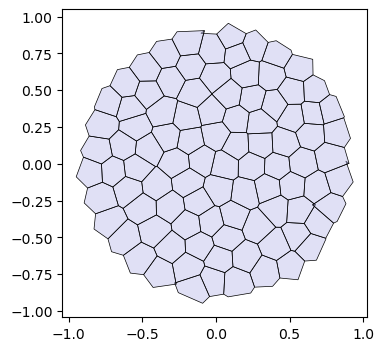

In [6]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.add_collection(msh.cellplot(hemesh, geommesh.face_positions,
                               cell_colors=np.array([0.7, 0.7, 0.9, 0.4]),
                               mpl_polygon_kwargs={"lw": 0.5, "ec": "k"}))
ax.set_aspect("equal")
ax.autoscale_view();

### Voronoi geometry and area-perimeter energy 

In [7]:
def get_voronoi_perimeters(vertices: Float[jax.Array, "n_vertices dim"], hemesh: msh.HeMesh) -> Float[jax.Array, " n_vertices"]:
    """Compute Voronoi perimeters for each vertex."""
    voronoi_lengths = geom.get_voronoi_edge_lengths(vertices, hemesh)
    cell_perims = adj.sum_he_to_vertex_incoming(hemesh, voronoi_lengths)
    return cell_perims

In [8]:
@jax.jit
def energy_ap(geommesh: GeomMesh, hemesh: HeMesh, a0: float, p0: float,
              k_a: float = 1.0, k_p: float = 1.0, k_penalty: float=10) -> Float[jax.Array, ""]:
    """Area-perimeter energy for Voronoi cells.
    Adds small penalty for triangles with negative area.
    """
    cell_areas = geom.get_voronoi_areas(geommesh.vertices, hemesh)    
    cell_perimeters = get_voronoi_perimeters(geommesh.vertices, hemesh)
    tri_areas = geom.get_oriented_triangle_areas(geommesh.vertices, hemesh)
    # add a factor 2x for boundary vertices to account for missing triangles
    cell_areas = jnp.where(hemesh.is_bdry, 2.0 * cell_areas, cell_areas)
    cell_perimeters = jnp.where(hemesh.is_bdry, 2.0 * cell_perimeters, cell_perimeters)

    a_min = 0.25*(a0/2)
    penality = jnp.where(tri_areas < a_min, k_a * (tri_areas-a_min)**2, 0.0).mean()

    return k_a*jnp.mean((cell_areas-a0)**2) + k_p * jnp.mean((cell_perimeters-p0)**2) + k_penalty*penality

In [9]:
cell_areas, cell_perimeters = (geom.get_voronoi_areas(geommesh.vertices, hemesh),
                               get_voronoi_perimeters(geommesh.vertices, hemesh))

a_mean, p_mean = (cell_areas[~hemesh.is_bdry].mean(), cell_perimeters[~hemesh.is_bdry].mean())
a_mean, p_mean, p_mean/np.sqrt(a_mean)

(Array(0.02756258, dtype=float64),
 Array(0.63463959, dtype=float64),
 Array(3.82267399, dtype=float64))

In [10]:
%%timeit
energy_ap(geommesh, hemesh, a0=a_mean, p0=3*jnp.sqrt(a_mean))

67.2 μs ± 397 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
grad_energy = jax.jit(jax.grad(energy_ap))

In [12]:
%%timeit
grad_energy(geommesh, hemesh, a0=a_mean, p0=3*jnp.sqrt(a_mean))

177 μs ± 25.7 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Edge flips

After each timestep, we need to check if the Voronoi edge lengths are below some threshold (the edge lengths can be computed on the fly), and, if so, we need to carry out edge flips. See notebook 03. We need to ensure that we do not immidiately "re-flip" an edge. This can be done via "cool down" period (an edge flipped at step $t$ cannot be flipped again for the next few steps).

In [13]:
@functools.partial(jax.jit, static_argnames=['cooldown_steps', 'max_flips'])
def apply_flips(geommesh: GeomMesh, hemesh: HeMesh, l_min_T1: float, 
                cooldown_counter: Int[jax.Array, " n_hes"], cooldown_steps: int, max_flips: int = 10
                ) -> Tuple[HeMesh, Int[jax.Array, " n_hes"], Bool[jax.Array, " n_hes"],]:
    """
    Apply T1 edge flips with a per-edge cooldown.
    
    Flipps edges if they are shorter than l_min_T1. Bondary edges are not flipped.

    Only flips the max_flips shortest edges for efficiency.
    """
    edge_lengths = geom.get_voronoi_edge_lengths(geommesh.vertices, hemesh)

    allow_flip = (cooldown_counter == 0) & hemesh.is_unique & ~hemesh.is_bdry_edge
    edge_lengths = jnp.where(allow_flip, edge_lengths, 1000)
    ids = jnp.argsort(edge_lengths)[:max_flips]
    
    hemesh_next = flip_by_id(hemesh, ids, edge_lengths[ids] < l_min_T1)
    did_flip = (edge_lengths < l_min_T1) & (edge_lengths < edge_lengths[ids[-1]])    
    cooldown_counter = jnp.where(did_flip, cooldown_steps, jnp.clip(cooldown_counter-1, 0))

    return hemesh_next, cooldown_counter, did_flip


In [14]:
hemesh_next, cooldown_counter, did_flip = apply_flips(geommesh, hemesh, l_min_T1=0.0,
                                                      cooldown_counter=0*jnp.ones(hemesh.n_hes),
                                                      cooldown_steps=1, max_flips=10)
did_flip.sum()


Array(4, dtype=int64)

In [15]:
%%timeit

_ = apply_flips(geommesh, hemesh, l_min_T1=0.0, cooldown_counter=jnp.zeros(hemesh.n_hes, dtype=jnp.int32), cooldown_steps=5,
                 max_flips=10) 
                 
# 100mus for single flip. 110 mus for 10 flips/tpt, 600 mus for scanning over and flipping all edges.

97.6 μs ± 2.65 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Energy relaxation (no self-propulsion)

We first only relax the area–perimeter energy. We also need to allow for topological modifications of the mesh (T1s/edge flips). At every timestep, we check if any dual cell edge has negative length and flip it. To ensure we don't flip the same edge multiple times, let's use a cooldown period.

In [16]:
# energy parameters
a0 = a_mean
s0 = 3
p0 = s0*jnp.sqrt(a0)

# numerical parameters
step_size = 0.02
n_steps = 10000

cooldown_steps = 5
l_min_T1 = 0.0

cooldown_counter=0*jnp.ones(hemesh.n_hes)

In [17]:
# relax energy
@jax.jit
def relax_energy_step(geommesh: GeomMesh, hemesh: HeMesh,
              a0: float, p0: float,
              step_size: float = 0.01,
              k_a: float = 1.0, k_p: float = 1.0) -> Tuple[GeomMesh, Float[jax.Array, ""]]:
    loss, grad = jax.value_and_grad(energy_ap)(geommesh, hemesh, a0, p0, k_a, k_p)
    updated_vertices = geommesh.vertices - step_size * grad.vertices
    geommesh_updated = dataclasses.replace(geommesh, vertices=updated_vertices)
    return geommesh_updated, loss

# package simulation time step into a function for jax.lax.scan
@jax.jit
def scan_fun(carry: Tuple[GeomMesh, HeMesh, Int[jax.Array, " n_steps"]], x: Float[jax.Array, " n_steps"]):
    (geommesh_relaxed, hemesh_relaxed), cooldown_counter = carry
    # step energy
    geommesh_relaxed, loss = relax_energy_step(geommesh_relaxed, hemesh_relaxed, a0, p0, step_size=step_size)
    # carry out T1s
    hemesh_relaxed, cooldown_counter, to_flip = apply_flips(geommesh_relaxed, hemesh_relaxed, l_min_T1,
                                                            cooldown_counter, cooldown_steps)
    #to_flip = jnp.zeros(2)

    # return updated carry and metrics
    log = jnp.array([loss, to_flip.sum()])

    return ((geommesh_relaxed, hemesh_relaxed), cooldown_counter), log

In [18]:
cooldown_counter = jnp.zeros(hemesh.n_hes)
sim_steps = jnp.arange(n_steps)

init = ((geommesh, hemesh), cooldown_counter)
((geommesh_relaxed, hemesh_relaxed), _), logs = jax.lax.scan(scan_fun, init, sim_steps) 

energy, flip_count = logs.T

(0.0, 7.0)

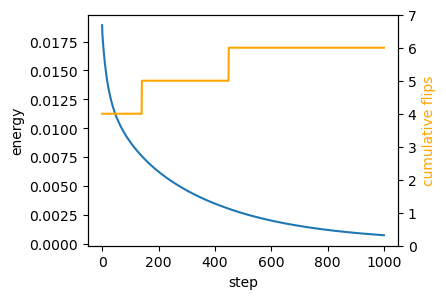

In [19]:
fig = plt.figure(figsize=(4, 3))
plt.plot(energy[::int(n_steps/1000)])
plt.xlabel("step")
plt.ylabel("energy")

# add a twin y axis that shows the cummulative number of flips
ax2 = plt.gca().twinx()
ax2.plot(jnp.cumsum(flip_count)[::int(n_steps/1000)], color="orange")
ax2.set_ylabel("cumulative flips", color="orange")
ax2.set_ylim([0,flip_count.sum()+1])

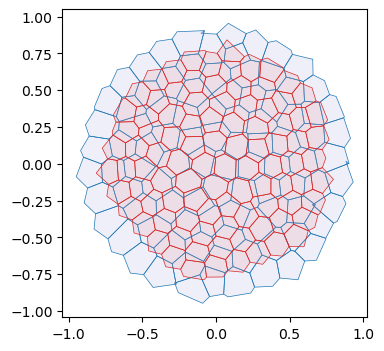

In [20]:
geommesh_relaxed = geom.set_voronoi_face_positions(geommesh_relaxed, hemesh_relaxed)

fig, ax = plt.subplots(figsize=(4, 4))
ax.add_collection(msh.cellplot(hemesh, geommesh.face_positions,
                               cell_colors=np.array([0.7, 0.7, 0.9, 0.2]),
                               mpl_polygon_kwargs={"lw": 0.5, "ec": "tab:blue"}))
ax.add_collection(msh.cellplot(hemesh_relaxed, geommesh_relaxed.face_positions,
                               cell_colors=np.array([0.9, 0.6, 0.6, 0.2]),
                               mpl_polygon_kwargs={"lw": 0.5, "ec": "tab:red"}))
ax.set_aspect("equal")
ax.autoscale_view();

## Overdamped dynamics with self-propulsion

omNext, let's add the self-propulsion term. We initialize the angles $\theta_i$ at random.
We can store the angles as an extra `vertex_attrib` in our `geommesh`, using the functionality of the `GeomMesh` dataclass. We already have an `IntEnum` which we can use as keys to the `vertex_attrib` dictionary, like described in notebook 01.

In addition to incorporating the self-propulusion term $\partial_t \mathbf{v}_i = -\nabla_{\mathbf{v}_i} E_{AP} + v_0\hat{\mathbf{n}}_i$, we need to do (stochastic) time steps for the angle orientation. Let's do that with `diffrax`'s SDE solver, like in [this tutorial](https://docs.kidger.site/diffrax/usage/getting-started/#stochastic-differential-equations-sdes). Let's also implement the "pattern" for simulation loops with `jax.lax.scan` Note that the simulation can diverge if the self-propulsion term is too strong, due to effects at the boundaries. A more carefull handling of the boundaries (adding T1s on the boundaries, or using periodic BCs) is beyond the scope of this notebook.

### Random numbers in JAX

JAX takes a [different approach](https://docs.jax.dev/en/latest/random-numbers.html) to random numbers (and hence the noise in our SDE) than numpy. The random numbers that will be used are specified by a `key` and will thus be reproducible across simulations. In particular, random numbers are no impediment to auto-differentiation; they are "frozen" when taking automatic derivatives.

In [31]:
## for this model, the simulation state becomes quite complex. Let's define a dataclass to hold it.

@jax.tree_util.register_dataclass
@dataclasses.dataclass
class SimState:
    geommesh: GeomMesh
    hemesh: HeMesh
    cooldown_counter: Int[jax.Array, " n_hes"]
    tprev: Float[jax.Array, ""]
    solver_state_sp: object
    solver_state_sde: object

## we also define a dataclass to hold logging information

@jax.tree_util.register_dataclass
@dataclasses.dataclass
class Log:
    geommesh: GeomMesh
    hemesh: HeMesh
    energy: Float[jax.Array, ""]
    n_flips: Int[jax.Array, ""]

In [32]:
# initialize orientations and store as a vertex attribute

class VertexAttribs(IntEnum):
    SP_ORIENTATION = 1

key = jax.random.key(0)
theta0 = jax.random.uniform(key, shape=(hemesh.n_vertices,), minval=0.0, maxval=2*jnp.pi)

geommesh_sp = dataclasses.replace(geommesh,
                                  vertex_attribs={VertexAttribs.SP_ORIENTATION: theta0})

hemesh_sp = copy.copy(hemesh)

In [33]:
## set simulation parameters

# energy parameters
a0 = a_mean
s0 = 3
p0 = s0*jnp.sqrt(a0)
v0 = 0.005 # self-propulsion speed
ka = 1.0
kp = 1.0

# orientation dynamics parameters
diffusion_coeff_theta = 1.0

# timestepping parameters
step_size = 0.02
n_steps = 5000

cooldown_steps = 5
l_min_T1 = 0.0

In [34]:
# check magnitude of the gradient forces vs the self-propulsion 

grad0 = jax.grad(energy_ap)(geommesh_sp, hemesh, a0, p0, 1, 1).vertices
sp0 = v0*jnp.stack([jnp.cos(theta0), jnp.sin(theta0)], axis=-1)

jnp.linalg.norm(sp0, axis=-1).mean() / jnp.linalg.norm(grad0, axis=-1).mean()

Array(1.5736791, dtype=float64)

In [35]:
## define the ODE for vertex positions

@jax.jit
def ap_selfprop_vector_field(t: Float[jax.Array, ""],
                             y: GeomMesh,
                             args: Tuple[HeMesh, float, float, float, float, float]) -> GeomMesh:
    """RHS for overdamped area-perimeter dynamics with self-propulsion."""
    hemesh, a0, p0, v0, k_a, k_p = args
    theta = y.vertex_attribs[VertexAttribs.SP_ORIENTATION]
    # combine energy gradient with self-propulsion
    grad = jax.grad(energy_ap)(y, hemesh, a0, p0, k_a, k_p)
    n_hat = jnp.stack([jnp.cos(theta), jnp.sin(theta)], axis=-1)
    velocity = -grad.vertices + v0 * n_hat
    # velocity = jnp.where(hemesh.is_bdry[:,None], 0, velocity)
    # don't update the orientations here
    zero_vertex_attribs = {key: jnp.zeros_like(val) for key, val in y.vertex_attribs.items()} 
    return dataclasses.replace(y, vertices=velocity, vertex_attribs=zero_vertex_attribs,)
term_sp = diffrax.ODETerm(ap_selfprop_vector_field)

## define the SDE and solver for orientation dynamics

key_sde = jax.random.key(0)
def diffusion(t, y, args):
    return lineax.DiagonalLinearOperator(diffusion_coeff_theta*jnp.ones(hemesh_sp.n_vertices))
def drift(t, y, args):
    return jnp.zeros(hemesh_sp.n_vertices)
brownian_motion =  diffrax.VirtualBrownianTree(0, step_size*n_steps,
                                               tol=1e-3, shape=(hemesh_sp.n_vertices,), key=key_sde)
term_sde = diffrax.MultiTerm(diffrax.ODETerm(drift), diffrax.ControlTerm(diffusion, brownian_motion))
## Define solvers

solver_sp = diffrax.Euler()
solver_sde = diffrax.EulerHeun()

In [36]:
# initialize the ancillary variables (solver state, cooldown)

solver_state_sp = solver_sp.init(term_sp, 0, step_size, geommesh_sp, (hemesh_sp, a0, p0, v0, ka, kp))
solver_state_sde = solver_sde.init(term_sde, 0, step_size, geommesh_sp.vertex_attribs[VertexAttribs.SP_ORIENTATION], None)

timepoints = step_size * jnp.arange(n_steps)

init = SimState(geommesh=geommesh_sp, hemesh=hemesh_sp,
                cooldown_counter= jnp.zeros(hemesh_sp.n_hes), tprev=timepoints[0],
                solver_state_sp=solver_state_sp, solver_state_sde=solver_state_sde)

In [37]:
# define the scan function - one step of the SDE + ODE coupled system

@jax.jit
def scan_fun(state: SimState, tnext: Float[jax.Array, ""],) -> tuple[SimState, Log]:
    # time-step SDE for self-propulsion orientation
    theta = state.geommesh.vertex_attribs[VertexAttribs.SP_ORIENTATION]
    theta, _, _, solver_state_sde, _ = solver_sde.step(term_sde, state.tprev, tnext, theta,
                                                       None, state.solver_state_sde, made_jump=False)
    # time-step ODE for vertex positions
    args_sp = (state.hemesh, a0, p0, v0, ka, kp,)
    geommesh, _, _, solver_state_sp, _ = solver_sp.step(term_sp, state.tprev, tnext, state.geommesh, args_sp,
                                                        state.solver_state_sp, made_jump=False,)
    geommesh = dataclasses.replace(geommesh, vertex_attribs={VertexAttribs.SP_ORIENTATION: theta})
    # T1 transitions for connectivity
    hemesh, cooldown_counter, to_flip = apply_flips(geommesh, state.hemesh,l_min_T1,
                                                    state.cooldown_counter, cooldown_steps,)
    
    # make measurements for log
    energy = energy_ap(geommesh, hemesh, a0, p0, ka, kp)
    n_flips=to_flip.sum()
    log = Log(geommesh=geommesh, hemesh=hemesh,
              energy=energy, n_flips=n_flips)
    # package next state
    next_state = SimState(geommesh=geommesh, hemesh=hemesh,
                          cooldown_counter=cooldown_counter, tprev=tnext,
                          solver_state_sp=solver_state_sp, solver_state_sde=solver_state_sde)
    
    return next_state, log

In [38]:
final_state, logs = jax.lax.scan(scan_fun, init, timepoints)

#### Numerical efficiency

`%%timeit` shows that the simulation run above take about 1.7s.
- The most expensive step is scanning for edge flips. You can probably accelerate the simulation a lot by checking only every $n$ steps.
- ODE solvers more complicated than `diffrax.Euler` perform worse, out of the box. You could likely use [adaptive timestepping](https://docs.kidger.site/diffrax/api/stepsize_controller/) to greatly accelerate the simulation.

In [146]:
%%timeit
# Time stepping: scan advances (tprev -> tnext) for both theta and vertex dynamics.
final_state, logs = jax.lax.scan(scan_fun, init, timepoints)

1.71 s ± 7.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
# Measurements logged at each step: geometry, connectivity, energy, and T1 flip counts.

geommesh_traj = msh.tree_unstack(logs.geommesh)
hemesh_traj = msh.tree_unstack(logs.hemesh)

### Visualize trajectory

In [40]:
# total displacement - about 50% of a cell distance

mean_edge_len = geom.get_he_length(geommesh.vertices, hemesh).mean()

np.linalg.norm(geommesh_traj[0].vertices-geommesh_traj[-1].vertices, axis=-1).mean() / mean_edge_len

Array(0.54363885, dtype=float64)

(0.0, 125.0)

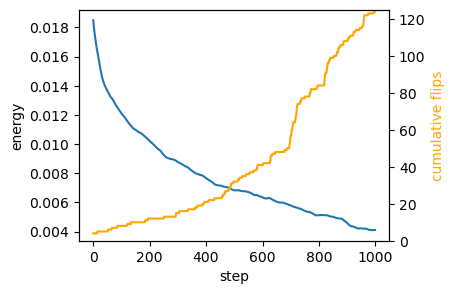

In [41]:
fig = plt.figure(figsize=(4, 3))

skip = int(np.ceil(n_steps/1000))
plt.plot(logs.energy[::skip])
plt.xlabel("step")
plt.ylabel("energy")

# add a twin y axis that shows the cummulative number of flips
ax2 = plt.gca().twinx()
ax2.plot(jnp.cumsum(logs.n_flips)[::skip], color="orange")
ax2.set_ylabel("cumulative flips", color="orange")
ax2.set_ylim([0,logs.n_flips.sum()+1])

Text(0, 0.5, 'orientation')

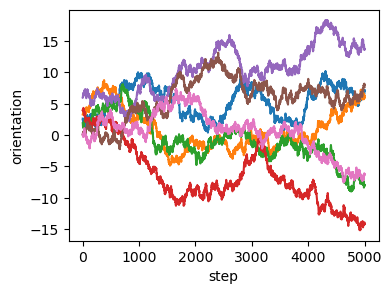

In [42]:
# angle dynamics are stochastic

fig = plt.figure(figsize=(4, 3))

cell_id = 50

plt.plot(logs.geommesh.vertex_attribs[VertexAttribs.SP_ORIENTATION][:, ::20])

plt.xlabel("step")
plt.ylabel("orientation")

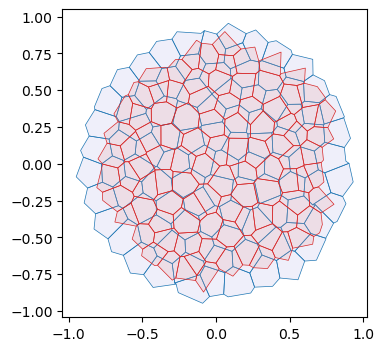

In [43]:
# plot initial and final mesh
fig, ax = plt.subplots(figsize=(4, 4))

geommesh_traj[-1] = geom.set_voronoi_face_positions(geommesh_traj[-1], hemesh_traj[-1])

ax.add_collection(msh.cellplot(hemesh_traj[0], geommesh_traj[0].face_positions,
                               cell_colors=np.array([0.7, 0.7, 0.9, 0.2]),
                               mpl_polygon_kwargs={"lw": 0.5, "ec": "tab:blue"}))
ax.add_collection(msh.cellplot(hemesh_traj[-1], geommesh_traj[-1].face_positions,
                               cell_colors=np.array([0.9, 0.6, 0.6, 0.2]),
                               mpl_polygon_kwargs={"lw": 0.5, "ec": "tab:red"}))


ax.set_aspect("equal")
ax.autoscale_view();


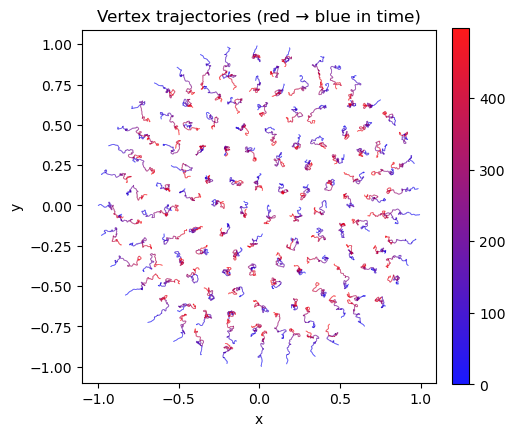

In [44]:
## plot trajectories of vertices (color = time: blue → red)

# logs.geommesh.vertices: (n_steps, n_vertices, 2), downsample in time 
stride = 10
X = np.asarray(logs.geommesh.vertices)[::stride] 
T = X.shape[0]

# Build line segments connecting consecutive time points for each vertex.
segments = np.stack([X[:-1], X[1:]], axis=2).reshape(-1, 2, 2)
t_idx = np.repeat(np.arange(T - 1), logs.geommesh.n_vertices)

cmap = mpl.colors.LinearSegmentedColormap.from_list("blue_to_red", ["blue", "red"])
norm = mpl.colors.Normalize(vmin=0, vmax=T - 2)

lc = mpl.collections.LineCollection(segments, cmap=cmap, norm=norm, linewidths=0.6, alpha=0.9)
lc.set_array(t_idx)

fig, ax = plt.subplots(figsize=(5, 5))
ax.add_collection(lc)
ax.set_aspect("equal")
ax.autoscale_view()
ax.set_title("Vertex trajectories (red → blue in time)")
ax.set_xlabel("x")
ax.set_ylabel("y")

cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)